In [1]:
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re

import gensim

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from keras.utils import np_utils
from keras import callbacks
from keras.layers import LSTM, SimpleRNN, GRU

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using Theano backend.


# LOAD DATA

In [2]:
df0_train_s = pd.read_pickle('../data/df0_train_s_ue0.pkl')
df0_test_s = pd.read_pickle('../data/df0_test_s_ue0.pkl')

In [3]:
select_cols = [u'pos_num', u'neg_num', u'pos', u'ef0', u'ef1', u'ef2', u'ef3', u'ef4', u'ef5', u'ef6', u'ef7', u'ef8', u'ef9']

In [4]:
train_x = np.c_[df0_train_s[select_cols].values, np.array((df0_train_s['sen_vec']).tolist())]
train_y = np.array(df0_train_s['polarity'])

test_x =  np.c_[df0_test_s[select_cols].values, np.array((df0_test_s['sen_vec']).tolist())]
test_y = np.array(df0_test_s['polarity'])

print 'train_x shape:',train_x.shape
print 'train_y shape:',train_y.shape

print 'test_x shape:',test_x.shape
print 'test_y shape:',test_y.shape

train_x shape: (5000, 513)
train_y shape: (5000,)
test_x shape: (5000, 513)
test_y shape: (5000,)


# MODEL TRAINING

## SOME PREPARATION

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def get_test_acc(test_x_cat,test_y,model):
    p1 = model.predict_proba(test_x_cat)
    return np.mean(test_y==(np.argmax(p1,axis=1)))
    

train_x_cat = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
test_x_cat = test_x.reshape(test_x_cat.shape[0],1,test_x_cat.shape[1])
train_y_cat = np_utils.to_categorical(train_y)
test_y_cat = np_utils.to_categorical(test_y)

## LSTM1

lr = 0.01

nesterov = False

epoch = 1000

batch_size = 32

In [6]:
from keras.optimizers import SGD

sgd = SGD()

model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=[1,train_x.shape[1]]))  # try using a GRU instead, for fun
model_lstm.add(Dense(10))
model_lstm.add(Activation('relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2))
model_lstm.add(Activation('softmax'))

model_lstm.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [7]:
model_lstm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 64)            147968      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            650         lstm_1[0][0]                     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 10)            0           activation_1[0][0]               
___________________________________________________________________________________________

In [8]:
history = model_lstm.fit(train_x_cat,train_y_cat,nb_epoch=500,validation_split=0.2,verbose=0)

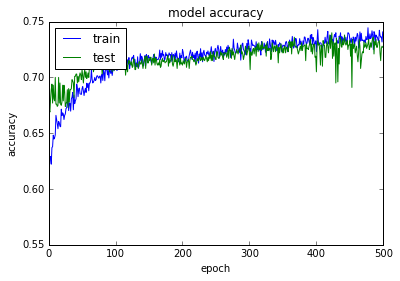

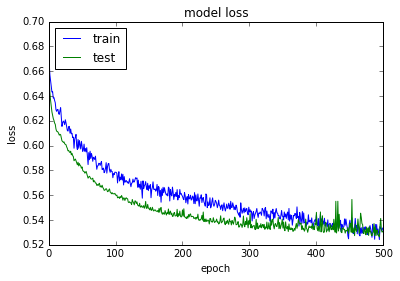

In [9]:
plot_history(history)

In [10]:
get_test_acc(test_x_cat,test_y,model_lstm)

4928/5000 [============================>.] - ETA: 0s

0.72619999999999996

## LSTM2

lr = 0.01

nesterov = True

epoch = 1000

batch_size = 32

In [11]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01,nesterov=True)

model_lstm2 = Sequential()
model_lstm2.add(LSTM(64, input_shape=[1,train_x.shape[1]]))  # try using a GRU instead, for fun
model_lstm2.add(Dense(10))
model_lstm2.add(Activation('relu'))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(2))
model_lstm2.add(Activation('softmax'))

model_lstm2.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [12]:
history2 = model_lstm2.fit(train_x_cat,train_y_cat,nb_epoch=500,validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/500
4000/4000 [==============================] - 1s - loss: 0.6917 - acc: 0.5252 - val_loss: 0.6885 - val_acc: 0.5690
Epoch 2/500
4000/4000 [==============================] - 1s - loss: 0.6847 - acc: 0.5860 - val_loss: 0.6813 - val_acc: 0.6470
Epoch 3/500
4000/4000 [==============================] - 1s - loss: 0.6798 - acc: 0.5897 - val_loss: 0.6746 - val_acc: 0.6560
Epoch 4/500
4000/4000 [==============================] - 1s - loss: 0.6742 - acc: 0.6070 - val_loss: 0.6683 - val_acc: 0.6700
Epoch 5/500
4000/4000 [==============================] - 1s - loss: 0.6685 - acc: 0.6205 - val_loss: 0.6624 - val_acc: 0.6630
Epoch 6/500
4000/4000 [==============================] - 1s - loss: 0.6649 - acc: 0.6140 - val_loss: 0.6572 - val_acc: 0.6720
Epoch 7/500
4000/4000 [==============================] - 1s - loss: 0.6586 - acc: 0.6202 - val_loss: 0.6517 - val_acc: 0.6610
Epoch 8/500
4000/4000 [==============================] - 1s - loss: 0.

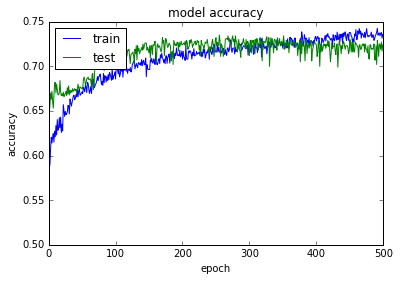

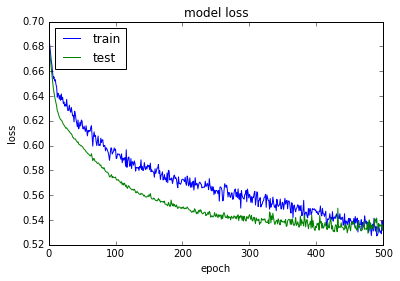

In [13]:
plot_history(history2)

In [14]:
get_test_acc(test_x_cat,test_y,model_lstm2)

4928/5000 [============================>.] - ETA: 0s

0.72719999999999996